# Описание проекта

К нам обратился фермер, владелец молочного хозяйства «Вольный луг». Он хочет купить бурёнок, чтобы расширить поголовье стада коров. Для этого он заключил выгодный контракт с ассоциацией пастбищ «ЭкоФерма».
Условия позволяют фермеру очень тщательно отобрать коров. Он определяет качество молока по строгой методике, и при этом ему нужно выполнять свой план развития молочного хозяйства. Фермер хочет, чтобы каждая бурёнка давала не менее 6000 килограммов молока в год, а её надой был вкусным — строго по его критериям, ничуть не хуже.

Для решения этой задачи нужно создать модель машинного обучения, которая поможет фермеру управлять рисками и принимать объективное решение о покупке. «ЭкоФерма» готова предоставить подробные данные о своих коровах. Нужно создать две прогнозные модели для отбора бурёнок в поголовье:

    - Первая будет прогнозировать возможный удой коровы (целевой признак Удой);
    - Вторая — рассчитывать вероятность получить вкусное молоко от коровы (целевой признак Вкус молока).
    
С помощью модели нужно отобрать коров по двум критериям:

    - средний удой за год — не менее 6000 килограммов;
    - молоко должно быть вкусным.

## Загрузка данных

Считаем данные и переименуем столбцы во всех датафреймах:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, precision_recall_curve

In [2]:
ferma_main = pd.read_csv('/datasets/ferma_main.csv', sep=';', decimal=',')
ferma_dad = pd.read_csv('/datasets/ferma_dad.csv', sep=';', decimal=',')
cow_buy = pd.read_csv('/datasets/cow_buy.csv', sep=';', decimal=',')

In [3]:
ferma_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     634 non-null    int64  
 1   Удой, кг                               634 non-null    int64  
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    float64
 3   Сырой протеин, г                       634 non-null    int64  
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    float64
 5   Порода                                 634 non-null    object 
 6   Тип пастбища                           634 non-null    object 
 7   порода папы_быка                       634 non-null    object 
 8   Жирность,%                             634 non-null    float64
 9   Белок,%                                634 non-null    float64
 10  Вкус молока                            634 non-null    object 
 11  Возрас

In [4]:
ferma_main.sample(10)

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
141,142,6502,16.1,1791,0.94,Вис Бик Айдиал,Равнинное,Соверин,3.74,3.078,не вкусно,более_2_лет
550,551,6406,14.7,1979,0.94,РефлешнСоверинг,Равнинное,Айдиал,3.71,3.075,не вкусно,более_2_лет
388,389,6472,16.2,2073,0.93,РефлешнСоверинг,Холмистое,Соверин,3.71,3.072,не вкусно,более_2_лет
398,399,5257,11.9,1793,0.89,Вис Бик Айдиал,Равнинное,Соверин,3.48,3.075,вкусно,менее_2_лет
277,278,6112,14.6,1988,0.93,РефлешнСоверинг,Холмистое,Соверин,3.73,3.075,не вкусно,более_2_лет
414,415,6293,13.5,2249,0.94,Вис Бик Айдиал,Холмистое,Айдиал,3.59,3.079,вкусно,более_2_лет
385,386,6416,14.0,2266,0.94,Вис Бик Айдиал,Холмистое,Айдиал,3.65,3.077,вкусно,более_2_лет
21,22,6278,14.6,1947,0.93,РефлешнСоверинг,Холмистое,Айдиалл,3.49,3.071,вкусно,более_2_лет
470,471,5638,13.1,2018,0.88,Вис Бик Айдиал,Равнинное,Соверин,3.62,3.077,вкусно,более_2_лет
401,402,5814,14.6,1794,0.89,Вис Бик Айдиал,Холмистое,Соверин,3.59,3.077,вкусно,более_2_лет


In [5]:
ferma_main = ferma_main.rename(columns={
    'Удой, кг': 'milk_yield_kg', 
    'ЭКЕ (Энергетическая кормовая единица)': 'EFU', 
    'Сырой протеин, г': 'raw_protein_g',
    'СПО (Сахаро-протеиновое соотношение)': 'SPR',
    'Порода': 'breed',
    'Тип пастбища': 'type_of_pasture',
    'порода папы_быка': 'breed_of_dad_bull',
    'Жирность,%': 'fatness_%',
    'Белок,%': 'protein_%',
    'Вкус молока': 'taste_of_milk',
    'Возраст': 'age'
})

ferma_main.head()

,id,milk_yield_kg,EFU,raw_protein_g,SPR,breed,type_of_pasture,breed_of_dad_bull,fatness_%,protein_%,taste_of_milk,age
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет


In [6]:
ferma_dad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


In [7]:
ferma_dad = ferma_dad.rename(columns={'Имя Папы': 'dad_name'})
ferma_dad.head()

,id,dad_name
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


In [8]:
cow_buy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Порода                   20 non-null     object 
 1   Тип пастбища             20 non-null     object 
 2   порода папы_быка         20 non-null     object 
 3   Имя_папы                 20 non-null     object 
 4   Текущая_жирность,%       20 non-null     float64
 5   Текущий_уровень_белок,%  20 non-null     float64
 6   Возраст                  20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


In [9]:
cow_buy = cow_buy.rename(columns={
    'Порода': 'breed',
    'Тип пастбища': 'type_of_pasture',
    'порода папы_быка': 'breed_of_dad_bull',
    'Имя_папы': 'dad_name',
    'Текущая_жирность,%': 'curr_fatness_%',
    'Текущий_уровень_белок,%': 'curr_protein_%',
    'Возраст': 'age'
})

cow_buy.head()

,breed,type_of_pasture,breed_of_dad_bull,dad_name,curr_fatness_%,curr_protein_%,age
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


В этом разделе были считаны данные в датафреймы, изучена общая информация

##  Предобработка данных

Обработаем датафрейм `ferma_main`:

In [10]:
ferma_main.head()

,id,milk_yield_kg,EFU,raw_protein_g,SPR,breed,type_of_pasture,breed_of_dad_bull,fatness_%,protein_%,taste_of_milk,age
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет


Обработаем дубликаты:

In [11]:
ferma_main.duplicated().sum()

5

In [12]:
ferma_main = ferma_main.drop_duplicates().reset_index(drop=True)

In [13]:
ferma_main.duplicated().sum()

0

Поищем неявные дубликаты:


In [14]:
print(ferma_main['type_of_pasture'].unique())
print(ferma_main['breed_of_dad_bull'].unique())

['Равнинное' 'Равнинные' 'Холмистое']
['Айдиал' 'Соверин' 'Айдиалл']


In [15]:
ferma_main['type_of_pasture'] = ferma_main['type_of_pasture'].str.replace('Равнинные', 'Равнинное')
ferma_main['breed_of_dad_bull'] = ferma_main['breed_of_dad_bull'].str.replace('Айдиалл', 'Айдиал')

In [16]:
print(ferma_main['type_of_pasture'].unique())
print(ferma_main['breed_of_dad_bull'].unique())

['Равнинное' 'Холмистое']
['Айдиал' 'Соверин']


Обработаем пропуски:

In [17]:
ferma_main.isna().sum()

id                   0
milk_yield_kg        0
EFU                  0
raw_protein_g        0
SPR                  0
breed                0
type_of_pasture      0
breed_of_dad_bull    0
fatness_%            0
protein_%            0
taste_of_milk        0
age                  0
dtype: int64

Аналогично обработаем датафрейм `cow_buy`:

In [18]:
cow_buy.head()

,breed,type_of_pasture,breed_of_dad_bull,dad_name,curr_fatness_%,curr_protein_%,age
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


Обработаем дубликаты:

In [19]:
cow_buy.duplicated().sum()

4

In [20]:
cow_buy = cow_buy.drop_duplicates().reset_index(drop=True)

In [21]:
cow_buy.duplicated().sum()

0

Обработаем пропуски:

In [22]:
cow_buy.isna().sum()

breed                0
type_of_pasture      0
breed_of_dad_bull    0
dad_name             0
curr_fatness_%       0
curr_protein_%       0
age                  0
dtype: int64

В этом разделе данные были предобработаны, а именно:
    
    - Удалены дубликаты (явные и неявные)
    - Обработаны пропуски

## Исследовательский анализ данных

Построим графики для каждого из признаков в датасете `ferma_main`:

In [23]:
def get_num_feature_plot(num_feature, title):
    fig, ax = plt.subplots(1, 2)
    plt.suptitle(title)
    ferma_main[num_feature].plot(kind='hist', ax=ax[0], figsize=(10, 7))
    ferma_main.boxplot(column=num_feature, ax=ax[1])
    plt.show()

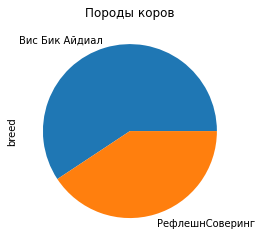

In [24]:
ferma_main['breed'].value_counts().plot(kind='pie', title='Породы коров')
plt.show()

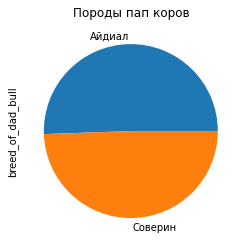

In [25]:
ferma_main['breed_of_dad_bull'].value_counts().plot(kind='pie', title='Породы пап коров')
plt.show()

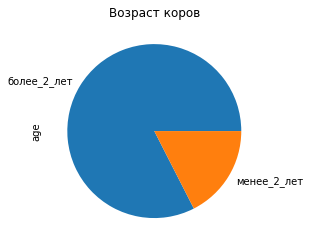

In [26]:
ferma_main['age'].value_counts().plot(kind='pie', title='Возраст коров')
plt.show()

In [27]:
ferma_main['EFU'].describe()

count    629.000000
mean      14.543879
std        1.306408
min       10.900000
25%       13.500000
50%       14.700000
75%       15.600000
max       16.800000
Name: EFU, dtype: float64

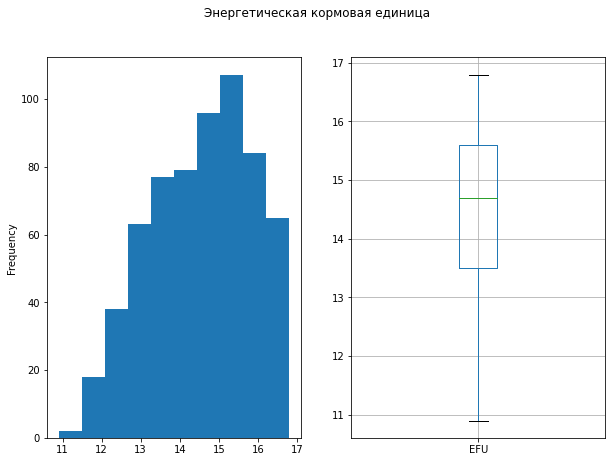

In [28]:
get_num_feature_plot('EFU', 'Энергетическая кормовая единица')

In [29]:
ferma_main['raw_protein_g'].describe()

count     629.000000
mean     1923.364070
std       182.956251
min      1660.000000
25%      1771.000000
50%      1888.000000
75%      2062.000000
max      2349.000000
Name: raw_protein_g, dtype: float64

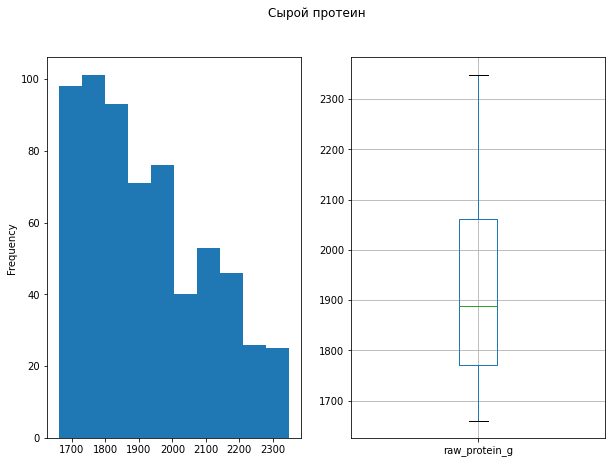

In [30]:
get_num_feature_plot('raw_protein_g', 'Сырой протеин')

In [31]:
ferma_main['SPR'].describe()

count    629.000000
mean       0.913116
std        0.032203
min        0.840000
25%        0.890000
50%        0.930000
75%        0.940000
max        0.960000
Name: SPR, dtype: float64

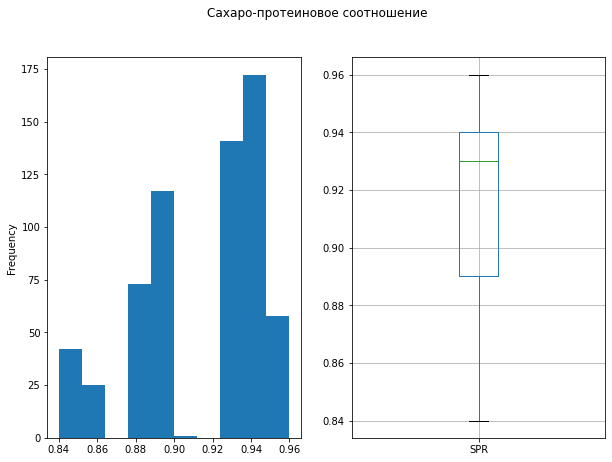

In [32]:
get_num_feature_plot('SPR', 'Сахаро-протеиновое соотношение')

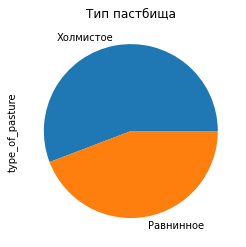

In [33]:
ferma_main['type_of_pasture'].value_counts().plot(kind='pie', title='Тип пастбища')
plt.show()

In [34]:
ferma_main['milk_yield_kg'].describe()

count      629.000000
mean      6188.750397
std       1644.795489
min       5204.000000
25%       5751.000000
50%       6133.000000
75%       6501.000000
max      45616.000000
Name: milk_yield_kg, dtype: float64

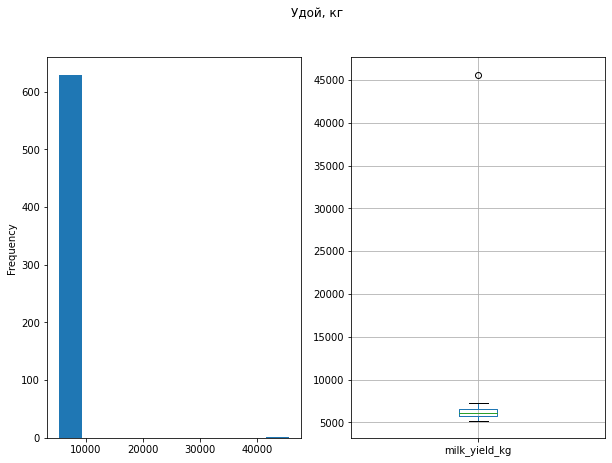

In [35]:
get_num_feature_plot('milk_yield_kg', 'Удой, кг')

Удалим выброс в столбце `milk_yield_kg`:

In [36]:
ferma_main = ferma_main[ferma_main['milk_yield_kg'] < 10000]

In [37]:
ferma_main['fatness_%'].describe()

count    628.000000
mean       3.604268
std        0.168093
min        2.990000
25%        3.590000
50%        3.650000
75%        3.720000
max        3.750000
Name: fatness_%, dtype: float64

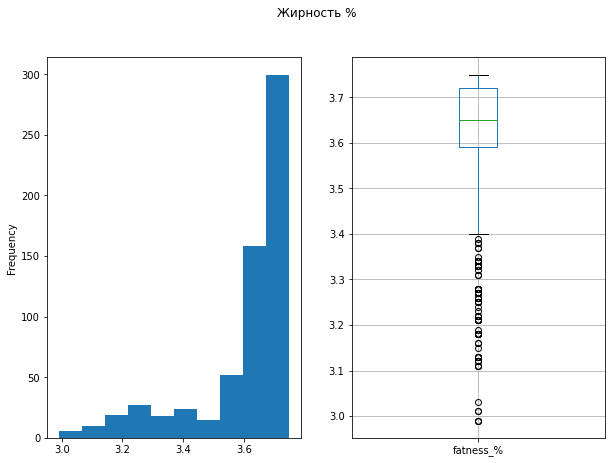

In [38]:
get_num_feature_plot('fatness_%', 'Жирность %')

In [39]:
ferma_main['protein_%'].describe()

count    628.000000
mean       3.075670
std        0.002551
min        3.069000
25%        3.074000
50%        3.076000
75%        3.077000
max        3.085000
Name: protein_%, dtype: float64

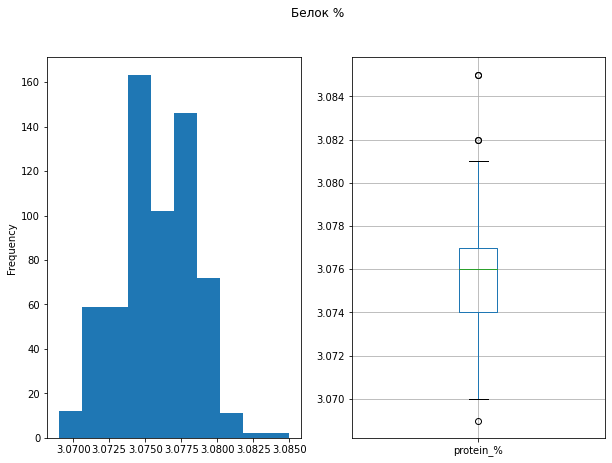

In [40]:
get_num_feature_plot('protein_%', 'Белок %')

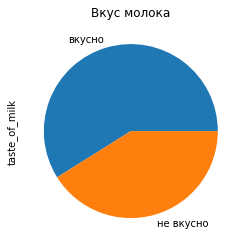

In [41]:
ferma_main['taste_of_milk'].value_counts().plot(kind='pie', title='Вкус молока')
plt.show()

Судя по графикам можно сделать следующие выводы:

    - У фермера коровы двух пород (Вис Бик Айдиал и РефлешнСоверинг), причём порода Вис Бик Айдиал немного преобладает
    - Коровы происходят от пород Айдиал и Соверин в равных пропорциях
    - ~ 80% поголовья фермера составляют коровы старше двух лет
    - Чаще всего энергетическая кормовая единица принимает значения из отрезка [15, 16] 
    - на графике распределения сырого протеина в молоке есть "провалы", но в целом с ростом содержания протеина кол-во коров, несущих такое молоко, падает
    - визуально гистограмму сахаро-протеинового соотношения можно разбить на три части ([0.84, 0.86], [0.88, 0.9], [0.92, 0.96])
    - Холмистый тип пастбища слегка преобладает над равнинным типом
    - Средний удой равен 6188 кг, но так же есть аномально великое значение в ~45000 кг, скорее всего это выброс
    - На графике распределения жирности молока заметен большой пик у значения 3.7 %
    - Распределение белка в молоке похоже на нормальное, так же заметен выброс на значении 3.084%
    - ~65 % молока вкусное, по оценкам фермера
    

В некоторых графиках есть "пробелы", чтоб от них избавиться потребуются дополнительные данные

## Корреляционный анализ

Из исследовательского анализа данных мы выяснили, что все количественнные признаки не распределены нормально, поэтому для нахождения матрицы корреляций используем метод Спирмена:

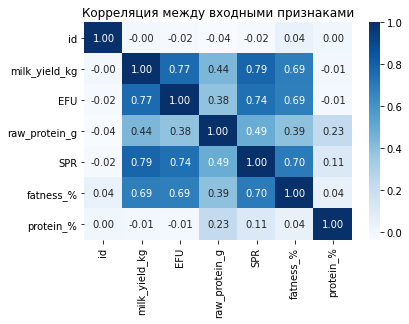

In [42]:
corr = ferma_main.corr(method='spearman')
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True, fmt='.2f', cmap="Blues").set(title='Корреляция между входными признаками')
plt.show()

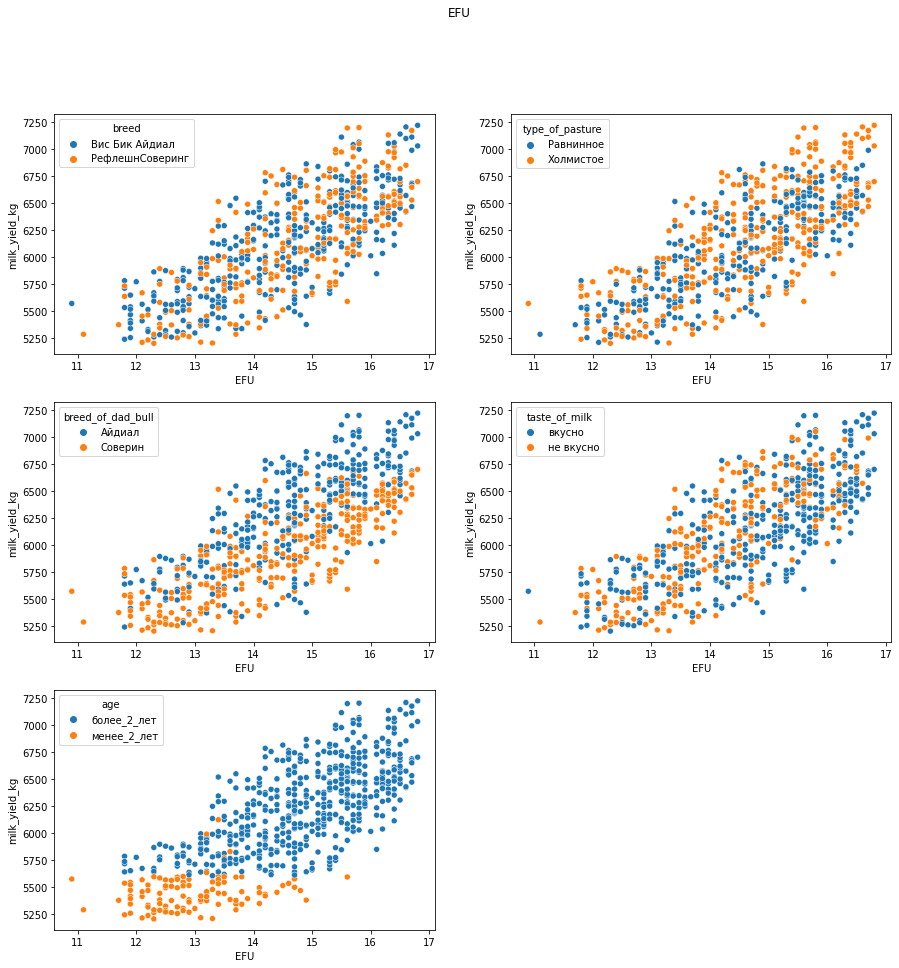

In [43]:
cat_features = ['breed', 'type_of_pasture', 'breed_of_dad_bull', 'taste_of_milk', 'age']


def get_scatterplot(num_feature, cat_features):
    fig, axes = plt.subplots(nrows=len(cat_features) // 2 + len(cat_features) % 2, ncols=2, figsize=(15, 15))
    for i, cat_feature in enumerate(cat_features):
        sns.scatterplot(data=ferma_main, y='milk_yield_kg', x=num_feature, hue=cat_feature, ax=axes.flatten()[i])
    if len(cat_features) % 2 == 1:
        fig.delaxes(axes[-1, -1])
    plt.suptitle(num_feature)
        
get_scatterplot('EFU', cat_features)

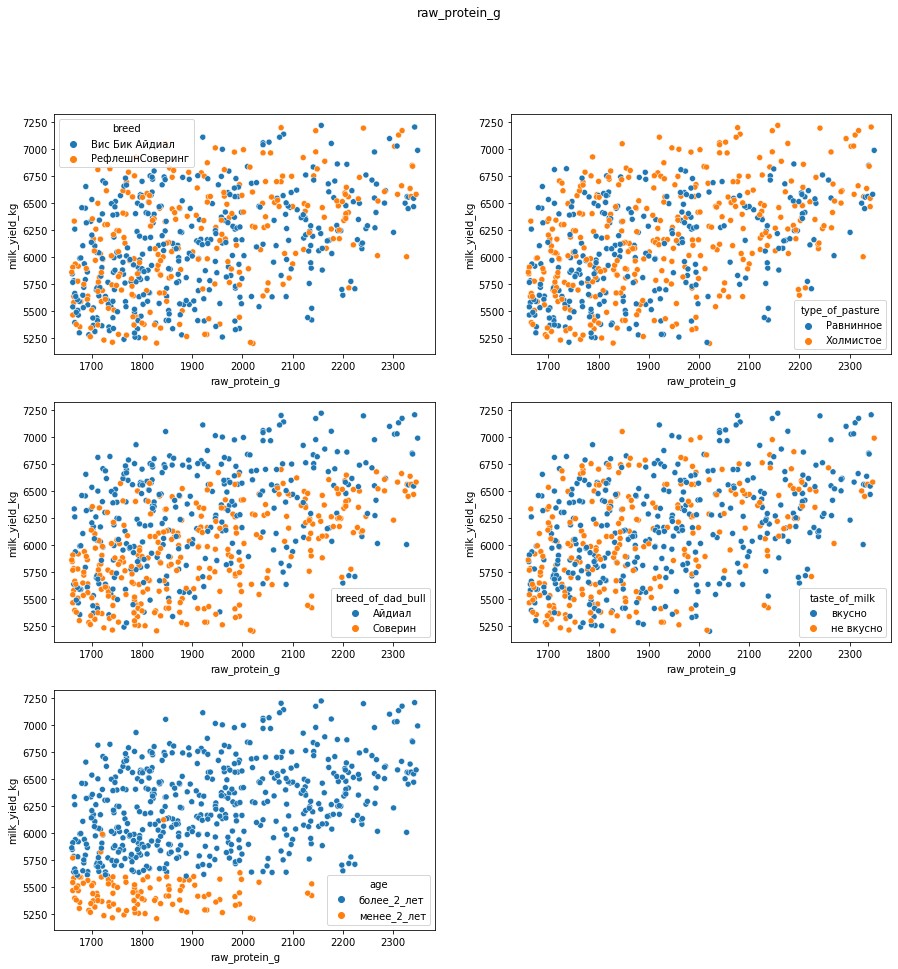

In [44]:
get_scatterplot('raw_protein_g', cat_features)

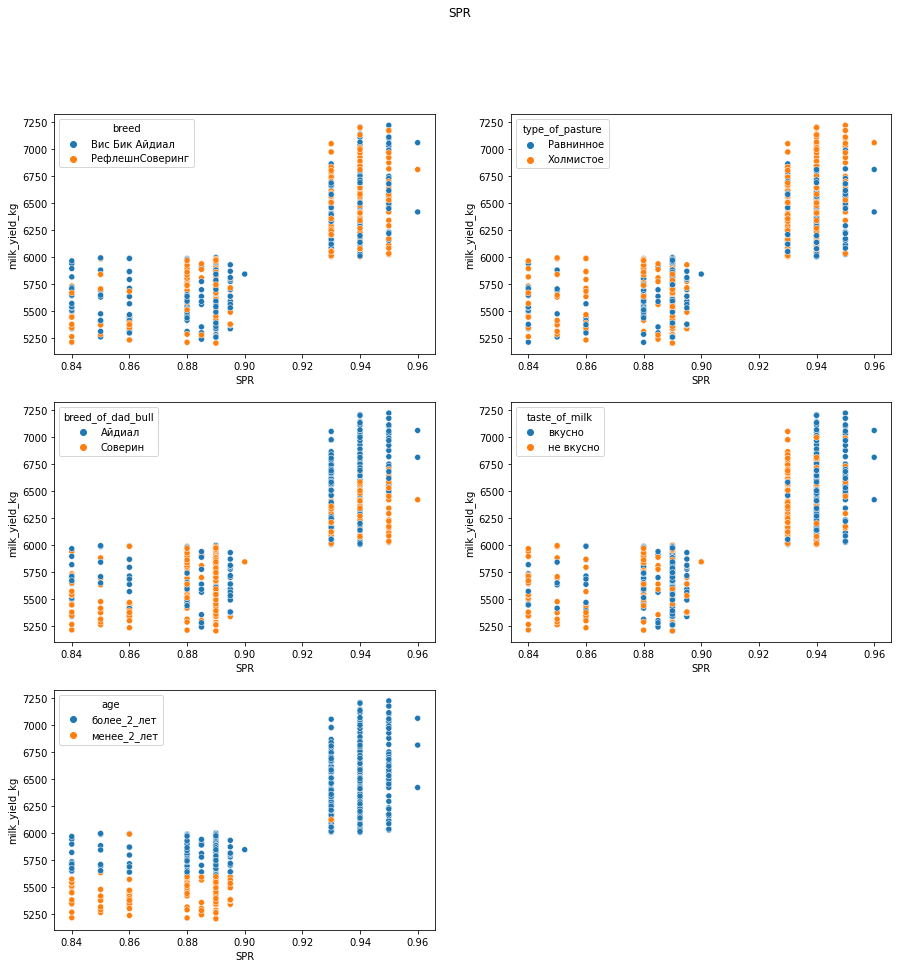

In [45]:
get_scatterplot('SPR', cat_features)

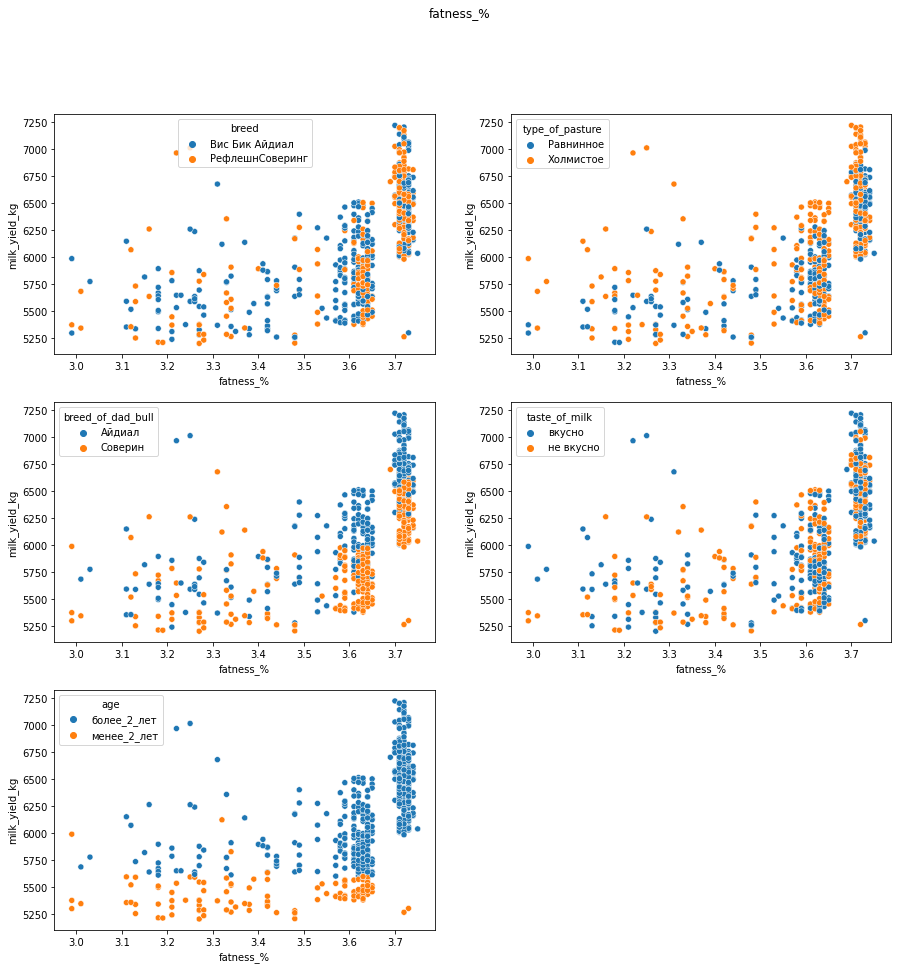

In [46]:
get_scatterplot('fatness_%', cat_features)

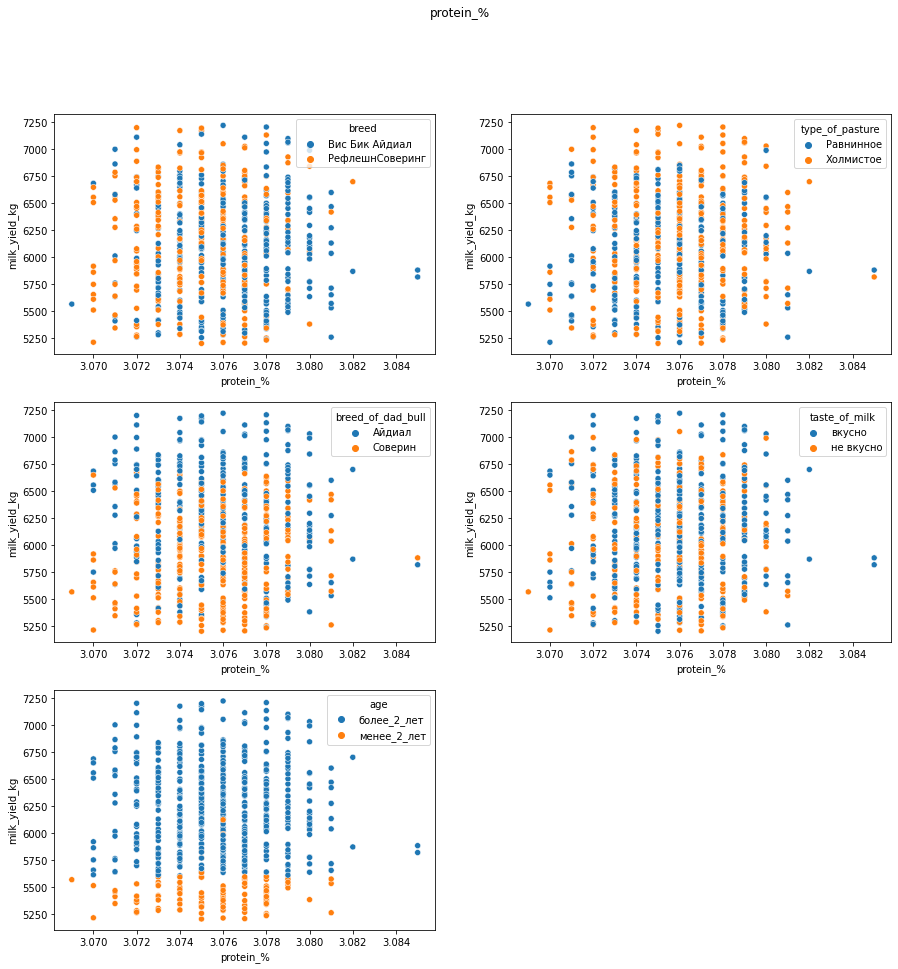

In [47]:
get_scatterplot('protein_%', cat_features)

Выводы:

    - взаимосвязь между признаком EFU с целевым квадратична
    - так же есть входные признаки, у которых отсутсвует связь с целевым, их не стоит учитывать при обучении моделей
    - есть мультиколлинеарные признаки, например EFU и SPR (коэффицент корреляции 0.75)

## Обучение модели линейной регрессии

In [48]:
ferma_main.head()

,id,milk_yield_kg,EFU,raw_protein_g,SPR,breed,type_of_pasture,breed_of_dad_bull,fatness_%,protein_%,taste_of_milk,age
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет


In [49]:
RANDOM_STATE = 42

X = ferma_main.drop(['milk_yield_kg', 'fatness_%', 'protein_%', 'taste_of_milk', 'id'], axis=1)
y = ferma_main['milk_yield_kg']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

cat_col_names = ['breed', 'type_of_pasture', 'breed_of_dad_bull', 'age']
num_col_names = ['EFU', 'SPR', 'raw_protein_g']

Промасштабируем количественные признаки, закодируем категориальные и объединим все признаки в один датасет:

In [50]:
def get_scaled_ohe_X(X_train, X_test, cat_col_names, num_col_names):
    scaler = StandardScaler()

    X_train_scaled = scaler.fit_transform(X_train[num_col_names])
    X_test_scaled = scaler.transform(X_test[num_col_names])

    encoder = OneHotEncoder(drop='if_binary', sparse=False)

    X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
    X_test_ohe = encoder.transform(X_test[cat_col_names])

    encoder_col_names = encoder.get_feature_names()

    X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
    X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

    X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

    X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
    X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)
    
    return X_train, X_test, scaler, encoder


X_train, X_test, lr_scaler1, lr_encoder1 = get_scaled_ohe_X(X_train, X_test, cat_col_names, num_col_names)

Обучим первую модель линейной регрессии:

In [51]:
model_lr1 = LinearRegression()

model_lr1.fit(X_train, y_train)

y_pred1 = model_lr1.predict(X_test)

r2_score = 0.784


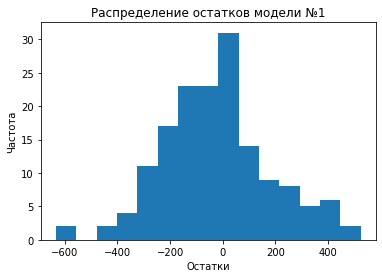

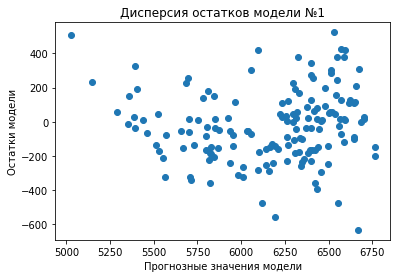

In [52]:
def get_analysis_of_model_residuals(y_test, y_pred, num):
    print(f'r2_score = {np.round(r2_score(y_test, y_pred), 3)}')
    
    (y_test - y_pred).plot(kind='hist', title=f'Распределение остатков модели №{num}', bins=15).set(xlabel='Остатки', ylabel='Частота')
    plt.show()
    
    plt.scatter(x=y_pred, y=y_test - y_pred)
    plt.title(f'Дисперсия остатков модели №{num}')
    plt.xlabel('Прогнозные значения модели')
    plt.ylabel('Остатки модели')
    plt.show()
    
    
get_analysis_of_model_residuals(y_test, y_pred1, 1)

##### Вывод по результатам предсказаний модели №1:

Коэффициент детерминации $R^2$ равен ~0.78, это означает, что в 78% случаях предсказания модели ближе к истине, чем среднее значение целевого признака

Судя по гистограмме остатков, можно сказать что их распределение не похоже на нормальное, есть выбросы и пики, значит модель работает не идеальным образом

Так же можно заметить, что дисперсия остатков непостоянна, значит модель ошибается неравномерно

Возможно были подобраны неподходящие входные признаки или некоторые из них связаны с целевым нелинейно, что плохо сказывается на точности предсказаний модели

##### Займёмся обучением второй модели линейной регрессии:

СПО и Удой связаны нелинейно. На их диаграмме рассеяния наблюдения сгруппированы в два кластера, причём есть такое значение СПО, которое можно считать границей между кластерами (~0.9). Чтобы устранить нелинейность, преобразуем СПО в категориальный бинарный признак, использовав эту границу

In [53]:
ferma_main['SPR_cat'] = ferma_main['SPR'].apply(lambda x: '>=0.915' if x >= 0.915 else '<0.915')

ЭКЕ и Удой также связаны нелинейно. Нелинейность между ними можно исключить, если ввести новый признак ЭКЕ в квадрате

In [54]:
ferma_main['EFU_sq'] = ferma_main['EFU'] * ferma_main['EFU']

In [55]:
ferma_main.head()

,id,milk_yield_kg,EFU,raw_protein_g,SPR,breed,type_of_pasture,breed_of_dad_bull,fatness_%,protein_%,taste_of_milk,age,SPR_cat,EFU_sq
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,<0.915,201.64
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет,<0.915,163.84
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет,<0.915,196.00
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,<0.915,153.76
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет,<0.915,163.84


In [56]:
X = ferma_main.drop(['milk_yield_kg', 'SPR', 'EFU', 'protein_%', 'taste_of_milk', 'id', 'fatness_%'], axis=1)
y = ferma_main['milk_yield_kg']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

cat_col_names = ['breed', 'type_of_pasture', 'breed_of_dad_bull', 'age', 'SPR_cat']
num_col_names = ['EFU_sq', 'raw_protein_g']

In [57]:
X_train, X_test, lr_scaler2, lr_encoder2 = get_scaled_ohe_X(X_train, X_test, cat_col_names, num_col_names)

In [58]:
model_lr2 = LinearRegression()

model_lr2.fit(X_train, y_train)

y_pred2 = model_lr2.predict(X_test)

r2_score = 0.818


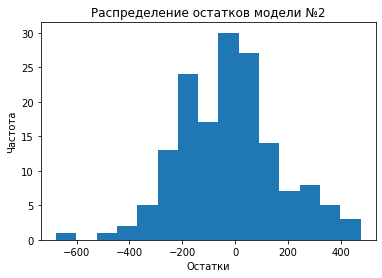

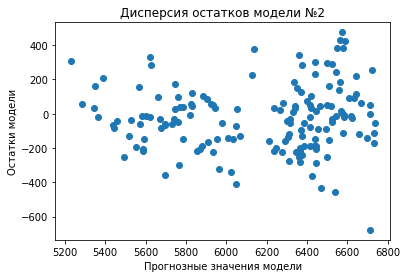

In [59]:
get_analysis_of_model_residuals(y_test, y_pred2, 2)

##### Вывод по результатам предсказаний модели №2:

Коэффициент детерминации $R^2$ равен ~0.82, это означает, что в 82% случаях предсказания модели ближе к истине, чем среднее значение целевого признака

Судя по гистограмме остатков, можно сказать что их распределение немного улучшилось, но есть выброс на значении -600, значит модель всё еще работает не идеальным образом, но лучше чем первая

Так же можно заметить, что дисперсия остатков стала более равномерной, это говорит о том, что качество второй модели выше чем у первой

##### Займёмся обучением третьей модели линейной регрессии:

In [60]:
ferma_main.head()

,id,milk_yield_kg,EFU,raw_protein_g,SPR,breed,type_of_pasture,breed_of_dad_bull,fatness_%,protein_%,taste_of_milk,age,SPR_cat,EFU_sq
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,<0.915,201.64
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет,<0.915,163.84
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет,<0.915,196.00
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,<0.915,153.76
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет,<0.915,163.84


In [61]:
ferma_dad.head()

,id,dad_name
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


In [62]:
ferma_main.shape, ferma_dad.shape

((628, 14), (629, 2))

In [63]:
ferma_main = ferma_main.merge(ferma_dad, how='left', on='id')

In [64]:
ferma_main.head()

,id,milk_yield_kg,EFU,raw_protein_g,SPR,breed,type_of_pasture,breed_of_dad_bull,fatness_%,protein_%,taste_of_milk,age,SPR_cat,EFU_sq,dad_name
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,<0.915,201.64,Буйный
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет,<0.915,163.84,Соловчик
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет,<0.915,196.00,Барин
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,<0.915,153.76,Буйный
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет,<0.915,163.84,Барин


In [65]:
X = ferma_main.drop(['milk_yield_kg', 'SPR', 'EFU', 'protein_%', 'taste_of_milk', 'id', 'fatness_%'], axis=1)
y = ferma_main['milk_yield_kg']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

cat_col_names = ['breed', 'type_of_pasture', 'breed_of_dad_bull', 'age', 'SPR_cat', 'dad_name']
num_col_names = ['EFU_sq', 'raw_protein_g']

In [66]:
X_train, X_test, lr_scaler3, lr_encoder3 = get_scaled_ohe_X(X_train, X_test, cat_col_names, num_col_names)

In [67]:
model_lr3 = LinearRegression()

model_lr3.fit(X_train, y_train)

y_pred3 = model_lr3.predict(X_test)

r2_score = 0.825


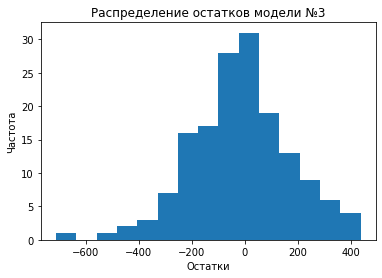

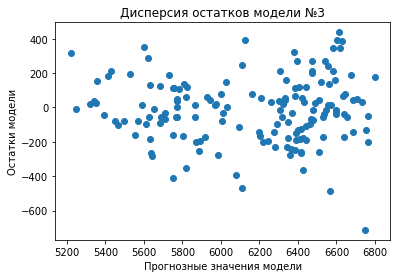

In [68]:
get_analysis_of_model_residuals(y_test, y_pred3, 3)

##### Вывод по результатам предсказаний модели №3:

Коэффициент детерминации $R^2$ равен ~0.83, это означает, что в 83% случаях предсказания модели ближе к истине, чем среднее значение целевого признака

Судя по гистограмме остатков, можно сказать что их распределение стало похоже на нормальное, значит третья модель лучше справляется с предсказаниями

Так же можно заметить, что дисперсия остатков стала ещё равномернее, это ещё раз подтверждает, что качество третьей модели выше остальных моделей

### Сопоставим метрики моделей и выберем из них лучшую:

In [69]:
def get_compare_table(y_test, y_predictions):
    df = pd.DataFrame(columns=['r2_score', 'MSE', 'RMSE', 'MAE'], index=[f'Модель №{i + 1}' for i in range(len(y_predictions))])
    df['r2_score'] = [np.round(r2_score(y_test, y_predictions[i]), 3) for i in range(len(y_predictions))]
    df['MSE'] = [np.round(mean_squared_error(y_test, y_predictions[i]), 3) for i in range(len(y_predictions))]
    df['RMSE'] = [np.round(mean_squared_error(y_test, y_predictions[i], squared=False), 3) for i in range(len(y_predictions))]
    df['MAE'] = [np.round(mean_absolute_error(y_test, y_predictions[i]), 3) for i in range(len(y_predictions))]
    return df


get_compare_table(y_test, [y_pred1, y_pred2, y_pred3])

,r2_score,MSE,RMSE,MAE
Модель №1,0.784,43887.015,209.492,164.242
Модель №2,0.818,37030.911,192.434,149.040
Модель №3,0.825,35673.890,188.875,146.163


Судя по полученным метрикам лучше всего с предсказыванием удоя коров справляется модель №3

In [70]:
rmse3 = np.round(mean_squared_error(y_test, y_pred3, squared=False), 3)
print(f"Доверительный интервал: [{y_pred3.mean() - 3 * rmse3}, {y_pred3.mean() + 3 * rmse3}]")
rmse3

Доверительный интервал: [5590.2325729563345, 6723.4825729563345]


188.875

Спрогнозируем удой коров:

In [71]:
cow_buy.head()

,breed,type_of_pasture,breed_of_dad_bull,dad_name,curr_fatness_%,curr_protein_%,age
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


In [72]:
cow_buy['type_of_pasture'] = cow_buy['type_of_pasture'].str.title()

cow_buy['EFU'] = ferma_main['EFU'].mean() * 1.05
cow_buy['SPR'] = ferma_main['SPR'].mean() * 1.05
cow_buy['raw_protein_g'] = ferma_main['raw_protein_g'].mean() * 1.05

cow_buy['SPR_cat'] = cow_buy['SPR'].apply(lambda x: '>=0.915' if x >= 0.915 else '<0.915')
cow_buy['EFU_sq'] = cow_buy['EFU'] * cow_buy['EFU']

cow_buy.head()

,breed,type_of_pasture,breed_of_dad_bull,dad_name,curr_fatness_%,curr_protein_%,age,EFU,SPR,raw_protein_g,SPR_cat,EFU_sq
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,0.958744,2019.947532,>=0.915,233.361138
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,15.276162,0.958744,2019.947532,>=0.915,233.361138
2,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.276162,0.958744,2019.947532,>=0.915,233.361138
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,15.276162,0.958744,2019.947532,>=0.915,233.361138
4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,15.276162,0.958744,2019.947532,>=0.915,233.361138


In [73]:
X = cow_buy.drop(['curr_protein_%', 'curr_fatness_%', 'SPR', 'EFU'], axis=1)

cat_col_names = ['breed', 'type_of_pasture', 'breed_of_dad_bull', 'age', 'SPR_cat', 'dad_name']
num_col_names = ['EFU_sq', 'raw_protein_g']

In [74]:
X_scaled = lr_scaler3.transform(X[num_col_names])
X_ohe = lr_encoder3.transform(X[cat_col_names])
encoder_col_names = lr_encoder3.get_feature_names()

X_ohe = pd.DataFrame(X_ohe, columns=encoder_col_names)
X_scaled = pd.DataFrame(X_scaled, columns=num_col_names)
X = pd.concat([X_ohe, X_scaled], axis=1)

# Проверка того, что порядок столбцов и названий совпадает у датасета на котором мы делаем fit и датасета на котором делам .transform
X.columns, X_train.columns

(Index(['x0_РефлешнСоверинг', 'x1_Холмистое', 'x2_Соверин', 'x3_менее_2_лет',
        'x4_>=0.915', 'x5_Барин', 'x5_Буйный', 'x5_Геркулес', 'x5_Соловчик',
        'EFU_sq', 'raw_protein_g'],
       dtype='object'),
 Index(['x0_РефлешнСоверинг', 'x1_Холмистое', 'x2_Соверин', 'x3_менее_2_лет',
        'x4_>=0.915', 'x5_Барин', 'x5_Буйный', 'x5_Геркулес', 'x5_Соловчик',
        'EFU_sq', 'raw_protein_g'],
       dtype='object'))

In [75]:
cow_buy['milk_yield_kg'] = model_lr3.predict(X)
cow_buy

,breed,type_of_pasture,breed_of_dad_bull,dad_name,curr_fatness_%,curr_protein_%,age,EFU,SPR,raw_protein_g,SPR_cat,EFU_sq,milk_yield_kg
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,0.958744,2019.947532,>=0.915,233.361138,6609.919297
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,15.276162,0.958744,2019.947532,>=0.915,233.361138,6378.711028
2,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.276162,0.958744,2019.947532,>=0.915,233.361138,6283.999775
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,15.276162,0.958744,2019.947532,>=0.915,233.361138,6593.089377
4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,15.276162,0.958744,2019.947532,>=0.915,233.361138,6542.146066
5,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,15.276162,0.958744,2019.947532,>=0.915,233.361138,6425.380218
6,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,15.276162,0.958744,2019.947532,>=0.915,233.361138,6571.259737
7,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,15.276162,0.958744,2019.947532,>=0.915,233.361138,6400.540668
8,Вис Бик Айдиал,Холмистое,Соверин,Соловчик,3.73,3.055,более_2_лет,15.276162,0.958744,2019.947532,>=0.915,233.361138,6344.707860
9,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.73,3.073,более_2_лет,15.276162,0.958744,2019.947532,>=0.915,233.361138,6617.928926


### Вывод по предсказаниям модели:

Таким образом, определив наилучшую модель, отмасштабировав и закодировав данные из датасета `cow_buy` получили прогноз удоя коров. Все коровы судя по предсказанию принесут более 6000 кг молока за год!!!

## Обучение модели логистической регрессии

In [76]:
ferma_main.head()

,id,milk_yield_kg,EFU,raw_protein_g,SPR,breed,type_of_pasture,breed_of_dad_bull,fatness_%,protein_%,taste_of_milk,age,SPR_cat,EFU_sq,dad_name
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,<0.915,201.64,Буйный
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет,<0.915,163.84,Соловчик
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет,<0.915,196.00,Барин
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,<0.915,153.76,Буйный
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет,<0.915,163.84,Барин


In [77]:
RANDOM_STATE = 42

X = ferma_main.drop(columns=['taste_of_milk', 'id', 'EFU_sq', 'raw_protein_g', 'EFU', 'SPR', 'SPR_cat', 'dad_name', 'breed_of_dad_bull'])
y = ferma_main['taste_of_milk'].apply(lambda x: 1 if x == 'вкусно' else 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

cat_col_names = ['breed', 'type_of_pasture', 'age']
num_col_names = ['milk_yield_kg', 'fatness_%', 'protein_%']

In [78]:
X_train, X_test, clf_scaler, clf_encoder = get_scaled_ohe_X(X_train, X_test, cat_col_names, num_col_names)

In [79]:
clf = LogisticRegression(random_state=RANDOM_STATE)

clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

accuracy: 0.592
recall: 0.864
precision: 0.594


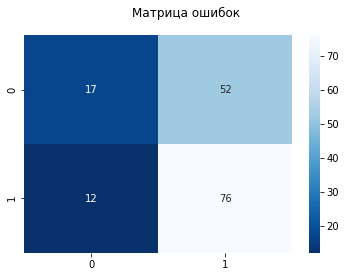

In [80]:
def get_clf_metrics(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    
    cm = confusion_matrix(y_test, y_pred)
    plt.suptitle('Матрица ошибок')
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
    
    return accuracy, recall, precision


acc, rec, prec = get_clf_metrics(y_test, y_pred)

print(f'accuracy: {acc:.3f}')
print(f'recall: {rec:.3f}')
print(f'precision: {prec:.3f}')

Так как фермеру важнее всего вкус молока, то наша ключевая задача состоит в правильном предсказании вкусного молока у коровы, то есть надо снизить количество ошибок FP, в этой ситауации фермер не купит корову, которая на самом деле будет давать невкусное молоко. Следовательно стоит обратить внимание на метрику precision (устремить её значение к 1)

In [81]:
y_proba = clf.predict_proba(X_test)[:, 1]
data = pd.DataFrame(zip(y_test, y_proba),
             columns = ['y_valid', 'y_proba']).sort_values(by='y_proba', ascending=False)

thresholds = [round(i, 2) for i in np.linspace(0.1, 1, num = 100, endpoint=False)]

columns = []

for i in thresholds:
    columns.append('y_pred_'+str(i))
    data['y_pred_' + str(i)] = data['y_proba'].apply(lambda x: 0 if x < i else 1)

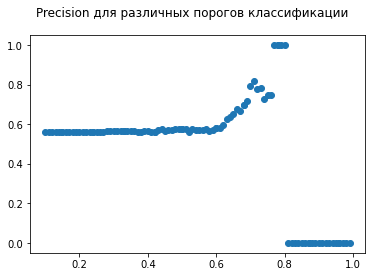

In [82]:
def get_precision(y_preds):

    plt.suptitle('Precision для различных порогов классификации')
    plt.scatter(x=thresholds, y=[precision_score(y_test, data[y_pred], zero_division=0) for y_pred in y_preds])
        
        
get_precision([f'y_pred_{i}' for i in thresholds])

In [83]:
proba = max([x for x in thresholds if x <= 0.75], key = lambda x: precision_score(y_test, data[f"y_pred_{x}"], zero_division=0))
proba

0.71

In [84]:
precision_score(y_test, data[f"y_pred_{proba}"], zero_division=0)

0.8181818181818182

Таким образом, оптимальный порог классификации равен 0.71, при нём метрика precision равна 0.81 

In [85]:
print(f'recall for y_pred_{proba} is: {recall_score(y_test, data[f"y_pred_{proba}"])}')

recall for y_pred_0.71 is: 0.20454545454545456


In [86]:
print(f'accuracy for y_pred_{proba} is: {accuracy_score(y_test, data[f"y_pred_{proba}"])}')

accuracy for y_pred_0.71 is: 0.5286624203821656


При пороге классификации равном 0.71 получили значение метрики recall = 0.20. Зато наша модель точно определяет всех коров, которые дают невкусное молоко, что не позволит фермеру купить корову, которая будет давать невкусное молоко. Осталось лишь спрогнозировать вкус молока на основе датасета `cow_buy`

In [87]:
cow_buy.head()

,breed,type_of_pasture,breed_of_dad_bull,dad_name,curr_fatness_%,curr_protein_%,age,EFU,SPR,raw_protein_g,SPR_cat,EFU_sq,milk_yield_kg
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,0.958744,2019.947532,>=0.915,233.361138,6609.919297
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,15.276162,0.958744,2019.947532,>=0.915,233.361138,6378.711028
2,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.276162,0.958744,2019.947532,>=0.915,233.361138,6283.999775
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,15.276162,0.958744,2019.947532,>=0.915,233.361138,6593.089377
4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,15.276162,0.958744,2019.947532,>=0.915,233.361138,6542.146066


In [88]:
RANDOM_STATE = 42

X = cow_buy.rename(columns={'curr_protein_%': 'protein_%', 'curr_fatness_%': 'fatness_%'})

cat_col_names = ['breed', 'type_of_pasture', 'age']
num_col_names = ['milk_yield_kg', 'fatness_%', 'protein_%']

X_scaled = clf_scaler.fit_transform(X[num_col_names])

X_ohe = clf_encoder.fit_transform(X[cat_col_names])

encoder_col_names = clf_encoder.get_feature_names()

X_ohe = pd.DataFrame(X_ohe, columns=encoder_col_names)
X_scaled = pd.DataFrame(X_scaled, columns=num_col_names)
X = pd.concat([X_ohe, X_scaled], axis=1)

# Проверка на правильность столбцов
X.columns, X_train.columns

(Index(['x0_РефлешнСоверинг', 'x1_Холмистое', 'x2_менее_2_лет', 'milk_yield_kg',
        'fatness_%', 'protein_%'],
       dtype='object'),
 Index(['x0_РефлешнСоверинг', 'x1_Холмистое', 'x2_менее_2_лет', 'milk_yield_kg',
        'fatness_%', 'protein_%'],
       dtype='object'))

In [89]:
cow_buy['taste_of_milk_predicted'] = pd.Series(clf.predict_proba(X)[:, 1]).apply(lambda x: 1 if x >= proba else 0)
cow_buy

,breed,type_of_pasture,breed_of_dad_bull,dad_name,curr_fatness_%,curr_protein_%,age,EFU,SPR,raw_protein_g,SPR_cat,EFU_sq,milk_yield_kg,taste_of_milk_predicted
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,0.958744,2019.947532,>=0.915,233.361138,6609.919297,1
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,15.276162,0.958744,2019.947532,>=0.915,233.361138,6378.711028,0
2,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.276162,0.958744,2019.947532,>=0.915,233.361138,6283.999775,0
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,15.276162,0.958744,2019.947532,>=0.915,233.361138,6593.089377,0
4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,15.276162,0.958744,2019.947532,>=0.915,233.361138,6542.146066,0
5,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,15.276162,0.958744,2019.947532,>=0.915,233.361138,6425.380218,0
6,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,15.276162,0.958744,2019.947532,>=0.915,233.361138,6571.259737,0
7,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,15.276162,0.958744,2019.947532,>=0.915,233.361138,6400.540668,0
8,Вис Бик Айдиал,Холмистое,Соверин,Соловчик,3.73,3.055,более_2_лет,15.276162,0.958744,2019.947532,>=0.915,233.361138,6344.707860,0
9,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.73,3.073,более_2_лет,15.276162,0.958744,2019.947532,>=0.915,233.361138,6617.928926,0


Найдём всех коров, которые подходят по требованиям фермера:

In [90]:
cow_buy[(cow_buy['milk_yield_kg'] > 6000) & (cow_buy['taste_of_milk_predicted'] == 1)]

,breed,type_of_pasture,breed_of_dad_bull,dad_name,curr_fatness_%,curr_protein_%,age,EFU,SPR,raw_protein_g,SPR_cat,EFU_sq,milk_yield_kg,taste_of_milk_predicted
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,0.958744,2019.947532,>=0.915,233.361138,6609.919297,1
13,Вис Бик Айдиал,Холмистое,Соверин,Соловчик,3.73,3.079,более_2_лет,15.276162,0.958744,2019.947532,>=0.915,233.361138,6344.707860,1


Таким образом нашлось 2 коровы, которые будут давать вкусный удой более 6000 кг в год. Но есть вероятность того, что корова будет давать невкусное молоко, а именно ~19% (1 - presicion). В качестве рекомендаций можно предложить поискать и добавить новые "характеристики" коров, их образа жизни и питания, которые могут в теории помочь улучшить предсказания моделей. Так же фермеру стоит попробовать назвать критерии по которым он определяет вкус молока (в данном проекте он не уточнил этого и пришлось рассуждать логически какие признаки подойдут для обучения модели)

### Выводы по построенным моделям:

1) Для улучшения работы модели линейной регрессии использовался поиск и создание входных параметров, от которых целевой признак зависит линейно

2) Улучшить качество модели линейной регрессии можно, если найти новые признаки или способы преобразовать старые, так чтоб целевой признак зависел от них линейно

3) Важнейшими метриками для оценки качества построенной модели являются метрики accuracy, recall и precision. В зависимости от поставленной задачи можно подобрать соответствующий порог классификации для улучшения работы модели. (Понять улучшилась ли работа модели можно по изменениям вышеперечисленных метрик)

## Итоговые выводы

К нам обратился фермер, владелец молочного хозяйства «Вольный луг». Он хочет купить бурёнок, чтобы расширить поголовье стада коров. Для этого он заключил выгодный контракт с ассоциацией пастбищ «ЭкоФерма».

Условия позволяют фермеру очень тщательно отобрать коров. Он определяет качество молока по строгой методике, и при этом ему нужно выполнять свой план развития молочного хозяйства. Фермер хочет, чтобы каждая бурёнка давала не менее 6000 килограммов молока в год, а её надой был вкусным — строго по его критериям, ничуть не хуже.

Для решения этой задачи были использованы модели линейной и логистической регрессии. Модель линейной регрессии предсказывает удой коров, а модель логистической регрессии - вкус молока. 

В ходе выполнения проекта были выполнены следующие действия:

1) Обработаны входные данные, удалены явные и неявные дубликаты, обработаны пропуски, данные приведены к правильным типам

2) Исследовано распределение данных

3) Проведён корреляционный анализ признаков

4) Построены три модели линейной регрессии. Из них выбрана лучшая по соответствующим метрикам ($R^2$, MSE, RMSE, MAE). Спрогнозирован удой коров

5) Построена модель логистической регрессии, которая предсказала вкус молока коров

В итоге, на основе предсказаний моделей, ни одна из коров не подошла под требования фермера.